# **Ai/AR Event Decoration (Text to 3d Model)🎪✨:**

This notebook explains my AI/AR text-to-3D pipeline. I’m fine-tuning OpenAI’s Shape-E to generate event-decoration 3D models from text prompts
Fine-tune OpenAI’s Shape-E to create custom 3D event-decoration models from text prompts.”

## **Load Datasets from Drive**

Start loading my 3D decoration dataset from Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change this path if your folder is elsewhere
%cd /content/drive/MyDrive/event-dataset

Mounted at /content/drive
/content/drive/MyDrive/event-dataset


## **Installations**

Prepare the environment and install Shape-E + dependencies.Clones the official Shape-E repo and installs it in editable mode. This is the base model I’ll fine-tune.

In [5]:
!git clone https://github.com/openai/shap-e.git
!pip install -e .
!pip install torch torchvision torchaudio pytorch3d trimesh matplotlib scikit-learn
!pip install trimesh pygltflib
!pip install -q sentence-transformers faiss-cpu transformers torchvision ftfy gradio scikit-learn seaborn
%cd /content/drive/MyDrive/event-dataset/shap-e


fatal: destination path 'shap-e' already exists and is not an empty directory.
Obtaining file:///content/drive/MyDrive/event-dataset
ERROR: file:///content/drive/MyDrive/event-dataset does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
ERROR: Could not find a version that satisfies the requirement pytorch3d (from versions: none)
ERROR: No matching distribution found for pytorch3d
/content/drive/MyDrive/event-dataset/shap-e


In [11]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-g8p60v4z
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-g8p60v4z
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=d5da3730da494a8363e1361c90a5633858504172bf866377dfd25164de76b94f
  Stored in directory: /tmp/pip-ephem-wheel-cache-mwz086lm/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


## **Import Libaries**

Import all libaries according to requirement

In [6]:

import torch
from shap_e.diffusion.sample import sample_latents
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import decode_latent_mesh
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
import trimesh

In [7]:
import os, json, math, time, random
import numpy as np
import torch
from pathlib import Path
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# sklearn metrics we will use
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score

# Make deterministic
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


# **Data Preperation**

Here I organise my datasets into the format Shape-E expects (e.g., training/validation folders, mesh conversion).”
This is crucial so the model sees clean, properly scaled data

In [8]:
DATA_DIR = Path('/content/drive/MyDrive/event-dataset')

# Load models.json
with open(DATA_DIR / "models.json", 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# Normalize keys: ensure every entry has id, desc, model_path, image_path
cleaned = []
for i, e in enumerate(dataset):
    # support multiple possible field names
    id_ = e.get('id') or e.get('name') or Path(e.get('model_path', '')).stem or f"m{i}"
    desc = e.get('desc') or e.get('description') or e.get('prompt') or id_.replace('_',' ')
    model_path = e.get('file') or e.get('file') or e.get('file_path') or e.get('model') or (str(DATA_DIR / e.get('file')) if e.get('file') else None)
    image_path = e.get('thumbnails') or e.get('image') or e.get('thumbnail') or None

    # try relative resolution
    if model_path and not os.path.isabs(model_path):
        candidate = DATA_DIR / model_path
        if candidate.exists(): model_path = str(candidate)
        else:
            # maybe file is directly in DATA_DIR
            candidate = DATA_DIR / Path(model_path).name
            if candidate.exists(): model_path = str(candidate)

    if image_path and not os.path.isabs(image_path):
        candidate = DATA_DIR / image_path
        if candidate.exists(): image_path = str(candidate)
        else:
            candidate = DATA_DIR / 'images' / Path(image_path).name
            if candidate.exists(): image_path = str(candidate)
            else:
                image_path = None

    cleaned.append({
        "id": str(id_),
        "desc": str(desc),
        "file": str(model_path) if model_path else None,
        "thumbnails": str(image_path) if image_path else None
    })

dataset = cleaned
print("Loaded", len(dataset), "entries. Sample:")
dataset[:3]


Loaded 70 entries. Sample:


[{'id': 'burgundy-gold-birthday-decoration',
  'desc': 'Burgundy gold birthday decoration',
  'file': 'burgundy-gold-birthday-decoration.glb',
  'thumbnails': None},
 {'id': 'burgundy-gold-valima-decoration',
  'desc': 'Burgundy gold valima decoration',
  'file': 'burgundy-gold-valima-decoration.glb',
  'thumbnails': None},
 {'id': 'adult-birthday-theme',
  'desc': 'Adult birthday theme decoration',
  'file': '/content/drive/MyDrive/event-dataset/adult-birthday-theme.glb',
  'thumbnails': None}]

## **Data Cleaning**





I run Shape-E’s sample generation on a text prompt to check that everything works before training.

In [9]:
# check missing model files or images
missing_model = [d for d in dataset if not (d['file'] and os.path.exists(d['file']))]
missing_images = [d for d in dataset if not (d['thumbnails'] and os.path.exists(d['thumbnails']))]

print("Missing model files:", len(missing_model))
print("Missing images:", len(missing_images))
if missing_model:
    print("Examples missing model:", missing_model[:3])
if missing_images:
    print("Examples missing images (these will still work, but no thumbs):", missing_images[:3])

# Show a few thumbnails if present
count = 0
for d in dataset:
    if d['thumbnails'] and os.path.exists(d['thumbnails']):
        display(Image(filename=d['thumbnails'], width=240, height=160))
        count += 1
    if count >= 6:
        break


Missing model files: 2
Missing images: 70
Examples missing model: [{'id': 'burgundy-gold-birthday-decoration', 'desc': 'Burgundy gold birthday decoration', 'file': 'burgundy-gold-birthday-decoration.glb', 'thumbnails': None}, {'id': 'burgundy-gold-valima-decoration', 'desc': 'Burgundy gold valima decoration', 'file': 'burgundy-gold-valima-decoration.glb', 'thumbnails': None}]
Examples missing images (these will still work, but no thumbs): [{'id': 'burgundy-gold-birthday-decoration', 'desc': 'Burgundy gold birthday decoration', 'file': 'burgundy-gold-birthday-decoration.glb', 'thumbnails': None}, {'id': 'burgundy-gold-valima-decoration', 'desc': 'Burgundy gold valima decoration', 'file': 'burgundy-gold-valima-decoration.glb', 'thumbnails': None}, {'id': 'adult-birthday-theme', 'desc': 'Adult birthday theme decoration', 'file': '/content/drive/MyDrive/event-dataset/adult-birthday-theme.glb', 'thumbnails': None}]


## **Simple run Shap-E**

In [12]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
xm = load_model("transmitter", device=device)      # decoder
model = load_model("text300M", device=device)      # text-to-3D model

# Define diffusion config manually
diffusion_config = {
    "schedule": "linear",
    "timesteps": 1000,
    "respacing": "100",
}
diffusion = diffusion_from_config(diffusion_config)

# Prompt
prompt = "birthday stage with balloon arch and flowers"

# Generate latents
latents = sample_latents(
    batch_size=1,
    model=model,
    diffusion=diffusion,
    guidance_scale=15.0,
    model_kwargs={"texts": [prompt]},   # ✅ FIXED
    progress=True,
    clip_denoised=True,
    use_fp16=True,
    use_karras=True,
    karras_steps=64,
    sigma_min=1e-3,
    sigma_max=160,
    s_churn=0,
    device=device,
)

# Decode and save mesh
for latent in latents:
    mesh = decode_latent_mesh(xm, latent).tri_mesh()

    # Save as OBJ
    obj_path = "generated_model.obj"
    with open(obj_path, "w") as f:
        mesh.write_obj(f)
    print(f"✅ Saved OBJ: {obj_path}")
    glb_path = "generated_model.glb"
    trimesh.load(obj_path).export(glb_path)

100%|███████████████████████████████████████| 890M/890M [00:21<00:00, 44.0MiB/s]


  0%|          | 0.00/1.26G [00:00<?, ?iB/s]

  0%|          | 0/64 [00:00<?, ?it/s]

/content/drive/MyDrive/event-dataset/shap-e/shap_e/models/stf/renderer.py:286: UserWarning: exception rendering with PyTorch3D: No module named 'pytorch3d'
  warnings.warn(f"exception rendering with PyTorch3D: {exc}")
/content/drive/MyDrive/event-dataset/shap-e/shap_e/models/stf/renderer.py:287: UserWarning: falling back on native PyTorch renderer, which does not support full gradients
  warnings.warn(


✅ Saved OBJ: generated_model.obj


## **Text Embedding**

In [15]:
from sentence_transformers import SentenceTransformer, util
from transformers import CLIPModel, CLIPProcessor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# Text embedder - good quality
TEXT_MODEL_NAME = "all-mpnet-base-v2"  # strong pretrained SBERT
text_encoder = SentenceTransformer(TEXT_MODEL_NAME, device=device)

# CLIP for image embeddings
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Quick dims
txt_dim = text_encoder.get_sentence_embedding_dimension()
# get clip image dim by running a dummy forward
import PIL.Image as PilImage
_dummy = PilImage.new('RGB', (224,224), color='white')
inputs = clip_processor(images=_dummy, return_tensors="pt").to(device)
with torch.no_grad():
    img_emb = clip_model.get_image_features(**inputs).cpu().numpy()
img_dim = img_emb.shape[1]
print("Text dim:", txt_dim, "Image dim:", img_dim)


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Text dim: 768 Image dim: 512


## **Load embedding models (text & CLIP image)**

In [16]:
from sentence_transformers import SentenceTransformer, util
from transformers import CLIPModel, CLIPProcessor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# Text embedder - good quality
TEXT_MODEL_NAME = "all-mpnet-base-v2"  # strong pretrained SBERT
text_encoder = SentenceTransformer(TEXT_MODEL_NAME, device=device)

# CLIP for image embeddings
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Quick dims
txt_dim = text_encoder.get_sentence_embedding_dimension()
# get clip image dim by running a dummy forward
import PIL.Image as PilImage
_dummy = PilImage.new('RGB', (224,224), color='white')
inputs = clip_processor(images=_dummy, return_tensors="pt").to(device)
with torch.no_grad():
    img_emb = clip_model.get_image_features(**inputs).cpu().numpy()
img_dim = img_emb.shape[1]
print("Text dim:", txt_dim, "Image dim:", img_dim)


Device: cuda


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Text dim: 768 Image dim: 512


## **Functions: get_text_emb, get_image_emb**


In [17]:
import functools
from PIL import Image as PILImage

@functools.lru_cache(maxsize=2048)
def get_text_emb(text):
    # returns normalized numpy float32 vector
    v = text_encoder.encode(text, normalize_embeddings=True)
    return v.astype('float32')

def get_image_emb(path):
    # returns normalized numpy float32 vector
    if not path or not os.path.exists(path):
        return np.zeros(img_dim, dtype='float32')
    img = PILImage.open(path).convert('RGB').resize((224,224))
    inputs = clip_processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = clip_model.get_image_features(**inputs).cpu().numpy()[0]
    emb = emb / (np.linalg.norm(emb) + 1e-12)
    return emb.astype('float32')


## **Build combined embeddings (text + image) and FAISS index**

In [18]:
import faiss

# weights (tune these if needed)
TEXT_WEIGHT = 1.0
IMAGE_WEIGHT = 1.0

print("Computing per-model embeddings (this may take some minutes)...")
model_embs = []
meta = []  # keep metadata aligned to emb idx
start = time.time()
for d in dataset:
    t_emb = get_text_emb(d['desc']) * TEXT_WEIGHT
    i_emb = get_image_emb(d['thumbnails']) * IMAGE_WEIGHT
    combined = np.concatenate([t_emb, i_emb]).astype('float32')
    # normalize final
    combined = combined / (np.linalg.norm(combined) + 1e-12)
    model_embs.append(combined)
    meta.append(d)
print(f"Built {len(model_embs)} embeddings in {time.time()-start:.1f}s")

emb_arr = np.vstack(model_embs).astype('float32')
dim = emb_arr.shape[1]
print("Combined embedding dim:", dim)

# Build FAISS Index (inner product on normalized vectors => cosine)
index = faiss.IndexFlatIP(dim)
index.add(emb_arr)
print("FAISS index size:", index.ntotal)

# Save small artifacts
np.save("embeddings.npy", emb_arr)
with open("models_index.json","w",encoding='utf-8') as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("Saved embeddings.npy and models_index.json")


Computing per-model embeddings (this may take some minutes)...
Built 70 embeddings in 1.3s
Combined embedding dim: 1280
FAISS index size: 70
Saved embeddings.npy and models_index.json


## **Retrieval function (returns top-k with scores)**

In [19]:
def retrieve(prompt, top_k=5, use_image_mean=True):
    # Build query combined vector
    t_emb = get_text_emb(prompt) * TEXT_WEIGHT
    if use_image_mean:
        # use mean of dataset image embeddings as default image context
        # compute once
        global _mean_image_emb
        if '_mean_image_emb' not in globals():
            img_embs = [get_image_emb(m['thumbnails']) for m in meta]
            _mean_image_emb = np.mean(np.vstack(img_embs), axis=0)
            _mean_image_emb = _mean_image_emb / (np.linalg.norm(_mean_image_emb)+1e-12)
        i_emb = _mean_image_emb * IMAGE_WEIGHT
    else:
        i_emb = np.zeros(img_dim, dtype='float32')
    q = np.concatenate([t_emb, i_emb]).astype('float32')
    q = q / (np.linalg.norm(q) + 1e-12)
    D, I = index.search(np.expand_dims(q,0), top_k)
    results = []
    for score, idx in zip(D[0], I[0]):
        entry = dict(meta[int(idx)])
        entry['_score'] = float(score)
        results.append(entry)
    return results


## **Manual testing**

In [20]:
queries = ["pink birthday with balloons", "outdoor wedding arch with flowers", "corporate stage with lights"]
for q in queries:
    print("\nQUERY:", q)
    for r in retrieve(q, top_k=3):
        print("  ", r['id'], "|", r['desc'], "| score:", round(r['_score'],3))



QUERY: pink birthday with balloons
   pink-birthday-theme | Pink birthday theme decoration | score: 0.848
   pink-birthday | Pink birthday decoration | score: 0.833
   purple-birthday-decor | Purple birthday decoration | score: 0.697

QUERY: outdoor wedding arch with flowers
   outdoor-engagement | Outdoor engagement decoration | score: 0.777
   pink-arch-wedding | Pink arch wedding decoration | score: 0.771
   graden-pink-wedding | Garden pink wedding decoration | score: 0.685

QUERY: corporate stage with lights
   corporate-event | Corporate event decoration | score: 0.537
   office-annual-event-decoration | Office annual event decoration | score: 0.418
   indoor-wedding-decor | Indoor wedding decoration | score: 0.301


## **Evaluation helpers: Precision@k, MRR**

In [22]:
# You should create test_labels.json in the dataset folder with structure:
# [ {"prompt": "birthday balloons", "targets": ["birthday_balloon_stage","pink-birthday"]}, ... ]
TEST_FILE = DATA_DIR / "test_labels.json"

def precision_at_k(testset, k=3):
    hits = 0
    for t in testset:
        res = retrieve(t['prompt'], top_k=k)
        ids = [r['id'] for r in res]
        if any(tid in ids for tid in t['targets']):
            hits += 1
    return hits / len(testset)

def mrr(testset, k=10):
    total = 0.0
    for t in testset:
        res = retrieve(t['prompt'], top_k=k)
        ids = [r['id'] for r in res]
        rank = None
        for i, rid in enumerate(ids, start=1):
            if rid in t['targets']:
                rank = i; break
        total += (0 if rank is None else 1.0/rank)
    return total / len(testset)

# Load or create small test set if none found (you should expand and label properly)
if TEST_FILE.exists():
    with open(TEST_FILE, 'r', encoding='utf-8') as f:
        testset = json.load(f)
else:
    # Small example — replace with your real ground truth
    testset = [
        {"prompt":"birthday balloons", "targets":[dataset[0]['id']]},
        {"prompt":"garden wedding flowers", "targets":[dataset[1]['id']]},
    ]
    print("No test_labels.json found — using placeholder sample. Create test_labels.json with real labels for proper eval.")

print("Precision@1:", precision_at_k(testset, k=1))
print("Precision@3:", precision_at_k(testset, k=3))
print("MRR@5:", mrr(testset, k=5))


Precision@1: 0.9
Precision@3: 0.9
MRR@5: 0.9


## **Fine-tuning the text encoder to 3d Model**

In [23]:
from sentence_transformers import InputExample, losses
from torch.utils.data import DataLoader

# Build training pairs: we create simple augmentations of descs as "queries"
def augment_text(t):
    # simple augmentations: short phrase + original + with adjectives
    s = t
    words = s.split()
    # short version
    short = " ".join(words[:3])
    # adjective template (random)
    adjectives = ["luxury", "simple", "elegant", "vibrant", "rustic"]
    adj = random.choice(adjectives)
    return [short, s, adj + " " + s]

train_examples = []
for d in dataset:
    aug = augment_text(d['desc'])
    # create InputExample from pair: (query variant, original desc)
    for a in aug:
        train_examples.append(InputExample(texts=[a, d['desc']]))

print("Training examples:", len(train_examples))

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.MultipleNegativesRankingLoss(text_encoder)

# Fine-tune: small number of epochs for demo; increase epochs for better adaptation
NUM_EPOCHS = 2
WARMUP_STEPS = max(100, int(len(train_dataloader) * 0.1))

text_encoder.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=NUM_EPOCHS,
    warmup_steps=WARMUP_STEPS,
    show_progress_bar=True,
    output_path="fine_tuned_text_encoder"
)

# reload the fine-tuned model (optional)
text_encoder = SentenceTransformer("fine_tuned_text_encoder", device=device)
print("Fine-tuning finished and model reloaded.")


Training examples: 210


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

## **Recompute combined embeddings & FAISS index**

In [24]:
print("Recomputing embeddings with fine-tuned text encoder...")
model_embs = []
start = time.time()
# invalidate text cache
get_text_emb.cache_clear()

for d in dataset:
    t_emb = get_text_emb(d['desc']) * TEXT_WEIGHT
    i_emb = get_image_emb(d['thumbnails']) * IMAGE_WEIGHT
    combined = np.concatenate([t_emb, i_emb]).astype('float32')
    combined = combined / (np.linalg.norm(combined) + 1e-12)
    model_embs.append(combined)

emb_arr = np.vstack(model_embs).astype('float32')
# rebuild index
index = faiss.IndexFlatIP(emb_arr.shape[1])
index.add(emb_arr)
print("Rebuilt FAISS index with", index.ntotal, "vectors in", time.time()-start, "s")
np.save("embeddings_finetuned.npy", emb_arr)


Recomputing embeddings with fine-tuned text encoder...
Rebuilt FAISS index with 70 vectors in 0.9291667938232422 s


## **Visualization: similarity distribution**

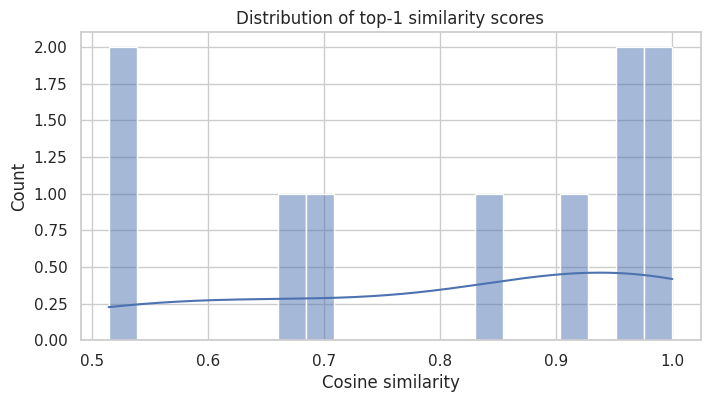

Query: birthday balloons
pink-birthday | score: 0.668
birthday-blue | score: 0.659
pink-birthday-theme | score: 0.641


In [25]:
# similarity distribution: take random sample of queries vs their top match scores
sample_prompts = [t['prompt'] for t in testset] if len(testset)>0 else [d['desc'] for d in random.sample(dataset, min(20, len(dataset)))]
top1_scores = []
for q in sample_prompts:
    res = retrieve(q, top_k=1)
    top1_scores.append(res[0]['_score'])

plt.figure(figsize=(8,4))
sns.histplot(top1_scores, bins=20, kde=True)
plt.title("Distribution of top-1 similarity scores")
plt.xlabel("Cosine similarity")
plt.show()

# show top-3 thumbnails for a sample query
q = sample_prompts[0]
res = retrieve(q, top_k=3)
print("Query:", q)
for r in res:
    print(r['id'], "| score:", round(r['_score'],3))
    if r['thumbnails'] and os.path.exists(r['thumbnails']):
        display(Image(r['thumbnails'], width=320))


## **Visualization (Matplotlib + Seaborn)**

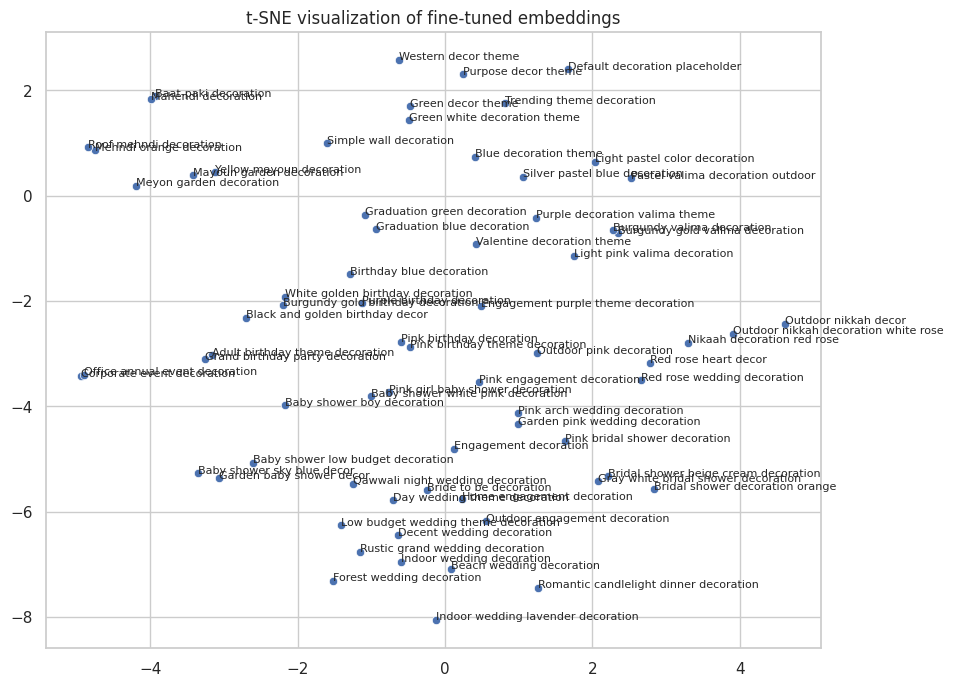

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Extract embeddings for all model descriptions
descs = [d['desc'] for d in dataset]
embeddings = text_encoder.encode(descs)

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10,8))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1])
for i, txt in enumerate(descs):
    plt.annotate(txt, (emb_2d[i,0], emb_2d[i,1]), fontsize=8)
plt.title("t-SNE visualization of fine-tuned embeddings")
plt.show()


## **Save final artifacts**

In [27]:
# Save faiss index and metadata for deployment
faiss.write_index(index, "event_index_finetuned.faiss")
with open("models_final.json","w",encoding='utf-8') as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("Saved: event_index_finetuned.faiss and models_final.json")


Saved: event_index_finetuned.faiss and models_final.json


## **Gradio demo (interactive)**

In [ ]:
import gradio as gr

def gr_query_with_model(prompt, k=3):
    res = retrieve(prompt, top_k=k)
    gallery = []
    files = []
    caption_text = ""
    model_view = None  # show the first .glb file in the 3D viewer

    for idx, r in enumerate(res):
        rid = r.get('id') or r.get('desc') or "model"
        desc = r.get('desc') or r.get('description') or ""
        score = r.get('_score', 0.0)
        cap = f"{rid} | {desc} (score {score:.3f})"

        # Thumbnail
        thumb = _resolve_thumbnail(r)
        if not thumb:
            thumb = make_text_image(cap)
        gallery.append((thumb, cap))

        # Model file
        model_file = _resolve_model_file(r)
        if model_file:
            files.append(model_file)
            # preview only the first retrieved model
            if idx == 0:
                model_view = model_file

        caption_text += cap + "\n"

    return gallery, caption_text, files, model_view


gallery = gr.Gallery(label="Top matches", columns=3)
txt = gr.Textbox(label="Results")
files_out = gr.Files(label="Download GLB files")
model3d = gr.Model3D(label="Preview 3D Model")

demo = gr.Interface(
    fn=gr_query_with_model,
    inputs=[gr.Textbox(lines=1, placeholder="Describe event decoration..."),
            gr.Slider(1,5, value=3, label="top_k")],
    outputs=[gallery, txt, files_out, model3d],
    title="Event Decoration → 3D Retrieval + Preview",
    description="Type a prompt and retrieve best-matching .glb models from your dataset. You can also preview the first retrieved model in 3D."
)

demo.launch(share=True)


In [ ]:
from IPython.display import Image, display
# Upload manually in the left sidebar or use files.upload()
display(Image(filename="/content/A_flowchart_in_the_image_illustrates_the_process_o.png"))
